# Dataset Preprocessing


In [1]:
import numpy as np 
from numpy.random import randint
from typing import Dict, List
from matplotlib import pyplot as plt
import cv2
import keras
from keras.datasets import mnist 
from tqdm.auto import tqdm

In [63]:
# Loads the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()


def dataSet_to_dict(data_images, data_labels) -> Dict[int,List[np.ndarray]]:

    numbers = {} 
    for img, label in zip(data_images, data_labels):
        if label not in numbers.keys():
            numbers[label] = []
        numbers[label] += [img]
    return numbers


def plot_data_dict(data:Dict[int,np.ndarray],figsize=[12, 6]) -> List[np.ndarray]:
    '''
        Plots the data 
        @param: data - Dict[int,np.ndarray]
    '''
    imageList = []
    cols = 5
    rows = (len(data.keys())/cols) + 1
    plt.figure(figsize=figsize)
    for index,key in enumerate(data.keys()):
      
        c = np.random.randint(len(data[key]),size = 1)[0]
        imageList.append(data[key][c])
        plt.subplot(rows,cols,index+1)
        plt.imshow(data[key][c] ,cmap = 'gray')
        plt.axis('off')
        plt.title(key)

    plt.show()
    return imageList
            

def scale_minMax(image):
    mini,maxi = np.min(image),np.max(image)
    return (image - mini)/(maxi-mini)

In [3]:
train_data = dataSet_to_dict(x_train, y_train)
test_data = dataSet_to_dict(x_test, y_test)


# show 5 samples of each class in the dataset

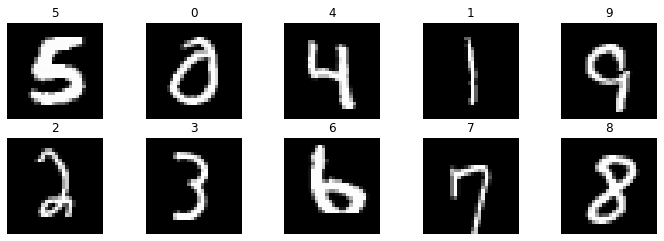

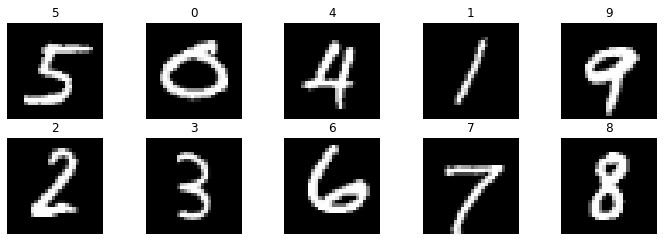

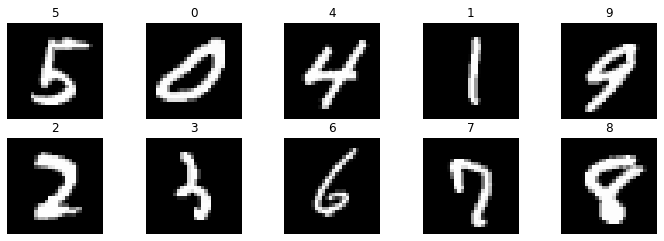

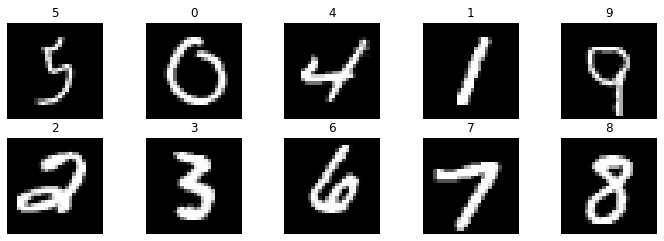

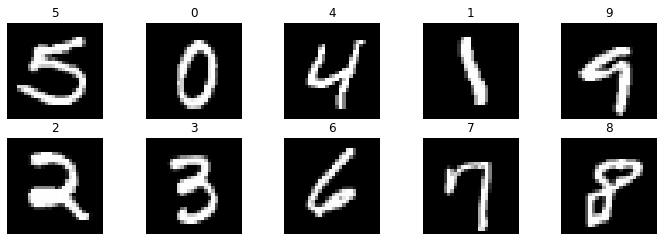

In [4]:
for _ in range(5):
  plot_data_dict(train_data)

In [5]:
def build_dataset(numbers, amount = 4000):
    dataset = {}
    print('0',end='')
    for hundreds,tens,unit in np.ndindex(2,10,10):
        key = 100*hundreds + 10*tens + unit

        if(key > 100):      
            break
    
        nset = np.array([])
        
        while len(nset) < amount:
            r_unit, r_tens, r_hundreds = randint(0,len(numbers[unit])),randint(0,len(numbers[tens])),randint(0,len(numbers[hundreds]))
            permutation = np.concatenate([numbers[hundreds][r_hundreds],numbers[tens][r_tens],numbers[unit][r_unit]], axis=1)
            if nset.size == 0:    
                nset = permutation.reshape([1,28,84])
            else:
                nset = np.append(nset, [permutation], axis=0)
                
            if len(nset) % amount == 0:
                nset = np.unique(nset,axis=0) # to make sure there are no redundent permutation of an image    

        dataset[key] = nset
        print('.', end='')

    print("100")
    return dataset

Building training set
: 0.....................................................................................................100

Building testing set
: 0.....................................................................................................100
Datasets are ready to used


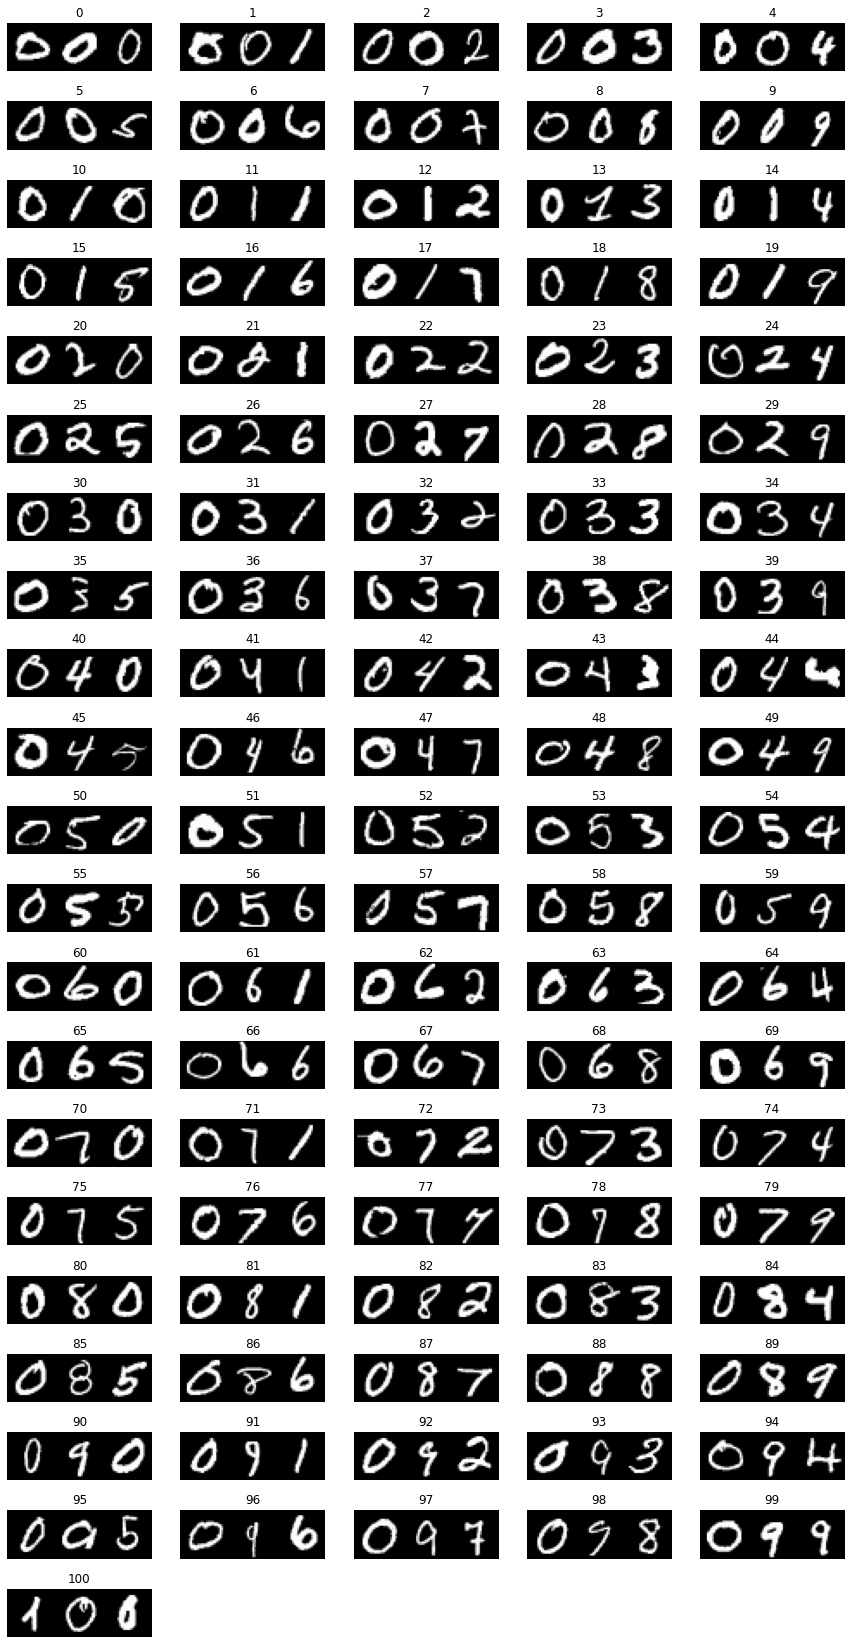

In [6]:
print('Building training set:')
new_train_data = build_dataset(train_data)
print('\nBuilding testing set:')
new_test_data = build_dataset(test_data)
print('Datasets are ready to used')


plot_data_dict(new_train_data,figsize=[15,30])

In [14]:
class Augmentation(object): 
    
    @staticmethod
    def flip(img:np.ndarray,axis:int) -> np.ndarray:
        return cv2.flip(img,axis)

    @staticmethod
    def rotate(img, angle:float)-> np.ndarray:
        centerH,centerW = img.shape[0]//2,img.shape[1]//2
        rotation_matrix = cv2.getRotationMatrix2D((centerW, centerH), angle, 1)
        return cv2.warpAffine(img, rotation_matrix, (img.shape[1],img.shape[0]))

    @staticmethod
    def gaussian_blur(img, ksize:int,sigma:int) -> np.ndarray:
        return cv2.GaussianBlur(img,ksize=(ksize,ksize),sigmaX=sigma, borderType=cv2.BORDER_DEFAULT)

    @staticmethod
    def median_blur(img, ksize:int) -> np.ndarray:
        return cv2.medianBlur(img,ksize)

    @staticmethod
    def zoom(img, zoom_factor:int)-> np.ndarray:

        height, width = img.shape[:2] 
        new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)

        h1, w1 = (new_height - height) // 2,(new_width - width) // 2
        h2, w2 = h1 + height, w1 + width

        pos = (np.array([h1, w1])/ zoom_factor).astype(int)
        size = (np.array([h2-h1,w2-w1]) / zoom_factor).astype(int)

        cropped_img = Augmentation.crop(img, tuple(pos), tuple(size))
        
        return cv2.resize(cropped_img, (width,height))

    @staticmethod
    def crop(img, pos:tuple, size:tuple) -> np.ndarray:
        newH = np.min([pos[0]+size[0],img.shape[0]])
        newW = np.min([pos[1]+size[1],img.shape[1]])     
        return img[pos[0]:newH,pos[1]:newW]


    @staticmethod
    def sobel(image,dx=1,dy=1):
        ddepth = cv2.CV_64F
        if len(image.shape) == 3:
             image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

        sobelx = cv2.Sobel(image,ddepth=ddepth,dx=1,dy=0)   
        if dx == 1 and dy == 0:
            return sobelx

        sobely = cv2.Sobel(image,ddepth=ddepth,dx=0,dy=1)
        if dx == 0 and dy == 1:
            return sobely
        return cv2.sqrt(cv2.addWeighted(cv2.pow(sobelx, 2.0), 1.0, cv2.pow(sobely,2.0), 1.0, 0.0))

    @staticmethod
    def canny(image,min_thresh=100,max_thresh=200):
        if len(image.shape) == 3:
             image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
        return cv2.Canny(image,min_thresh,max_thresh)

    @staticmethod
    def average_blur(image,ksize=3):
        kernel = np.ones([ksize,ksize], dtype=np.float32)/ksize**2
        return cv2.filter2D(image,-1,kernel)

    @staticmethod
    def salt_n_pepper_noise(image, s_vs_p = 0.5, amount = 0.004):
        out = np.copy(image)
        if len(image.shape) < 3:
            out = out.reshape([out.shape[0],out.shape[1],1])
        # Add salt
        salt = np.ceil(amount * image.size * s_vs_p).astype(int)
        coords = [np.random.randint(0, i - 1, size=salt) for i in image.shape]
        out[coords[0], coords[1], :] = 255

        # Add pepper
        pepper = np.ceil(amount * image.size * (1. - s_vs_p)).astype(int)
        coords = [np.random.randint(0, i - 1, size=pepper) for i in image.shape]
        out[coords[0], coords[1], :] = 0

        return out.reshape(image.shape)

    @staticmethod
    def guassian_noise(img,mean=0,sigma=5):
        noisey_image = img.copy()
        rows,cols = noisey_image.shape[:2]
        shape_original_image = 1 if len(noisey_image.shape) <= 2 else noisey_image.shape[2]
        if shape_original_image == 1:
            noise = np.random.normal(loc=mean, scale=sigma, size=(rows, cols))
            noisey_image[:rows, :cols] += noise.astype(noisey_image.dtype)
        else:
            noise = np.random.normal(loc=mean, scale=sigma,
                                     size=(rows, cols, noisey_image.shape[2]))
            for color in range(noisey_image.shape[2]):
                noisey_image[:rows, :cols] += noise.astype(noisey_image.dtype)

        return noisey_image

    @staticmethod
    def translate(image,dx=100,dy=50):
        rows,cols = image.shape[:2]
        M = np.float32([[1,0,dx],[0,1,dy]])
        return cv2.warpAffine(image,M,(cols,rows))
        
    @staticmethod
    def invert(image):
        return np.max(image)-image

    @staticmethod
    def emboss(image):
        kernel=np.array([[-2, -1, 0], 
                         [-1,  1, 1], 
                         [ 0,  1, 2]])
        return cv2.filter2D(image, -1, kernel)

    @staticmethod
    def erode(image, ksize=3, iterations=1):
        kernel = np.ones((ksize,ksize),np.uint8)
        return cv2.erode(image,kernel,iterations = iterations)
    
    @staticmethod
    def dilate(image, ksize=3, iterations=1):
        kernel = np.ones([ksize,ksize],np.uint8)
        return cv2.dilate(image,kernel,iterations = iterations)

    @staticmethod
    def scale(image, fx=0.5, fy=0.5, resize=False):
        rows,cols = image.shape[:2]
        scaled_image = cv2.resize(image, None, fx=fx, fy=fy, interpolation=cv2.INTER_CUBIC)
        if resize:
            scaled_image = cv2.resize(scaled_image,(cols,rows), interpolation=cv2.INTER_CUBIC)

        return scaled_image




In [71]:

class RandomAugmentation(Augmentation):
    

    noise = [func for func in dir(Augmentation) 
                        if callable(getattr(Augmentation, func)) 
                        and 'noise' in func]
    
    blur = [func for func in dir(Augmentation) 
                        if callable(getattr(Augmentation, func)) 
                        and 'blur' in func]
    
    augmentations = [func for func in dir(Augmentation) 
                        if callable(getattr(Augmentation, func)) 
                        and not func.startswith("__")
                        and 'blur' not in func 
                        and 'noise' not in func] + ['noise','blur']

    def __init__(self,images:List[np.ndarray], N:List[str]):
        ''' 
            N functions to use
        '''
        self.images = images
        self.N = N
        self.augmented_images = {}

    def random_noise(self,img):
        aug = np.random.choice(self.noise,1)
        if aug == 'guassian_noise':
            return 'guassian_noise,', super().guassian_noise(img)        
        elif aug == 'salt_n_pepper_noise':
            amount = np.random.uniform(0.0001,0.3,size=1)
            s_vs_p = np.random.uniform(0.1,0.6,size=1)
            return 'salt_n_pepper_noise,', super().salt_n_pepper_noise(img, s_vs_p, amount)

    def random_blur(self,img):
        aug = np.random.choice(self.blur,1)
        if aug == 'average_blur':
            ksize = np.random.randint(1,11)*2 +1
            return 'average_blur,', super().average_blur(img,ksize)

        elif aug == 'gaussian_blur':
            ksize = np.random.randint(1,11)*2 +1
            sigma = np.random.randint(1,9)
            return  'gaussian_blur,', super().gaussian_blur(img,ksize=ksize,sigma=sigma)

        elif aug ==  'median_blur':
            ksize = np.random.randint(1,11)*2 +1
            return 'median_blur,', super().median_blur(img, ksize=ksize)

    def augment_image(self, key, img, permutations:list):
        key+=':['

        if 'noise' in permutations:
            aug, img = self.random_noise(img)
            key+=aug
        
        if 'blur' in permutations:
            aug, img = self.random_blur(img)
            key+=aug

        if 'flip' in permutations:
            axis = np.random.randint(-1,1,1)
            img = super().flip(img=img,axis=axis)
            key+='flip,'
        
        if 'rotate' in permutations:
            angle = np.random.uniform(0, 360)
            img = super().rotate(img,angle=angle)
            key+='rotate,'

        if 'zoom' in permutations: 
            zoom = np.random.uniform(1,3)
            img = super().zoom(img, zoom_factor=zoom)
            key+='zoom,'

        if 'crop' in permutations:
            x = np.random.randint(10,img.shape[0])
            y = np.random.randint(10,img.shape[1])
            h = np.random.randint(10,img.shape[0])
            w = np.random.randint(10,img.shape[1])
            pos=(x,y)
            size=(h,w)
            img = super().crop(img, pos, size)
            key+='crop,'

        if 'emboss' in permutations:
            img = super().emboss(img)
            key+='emboss,'

        if 'canny' in permutations:
            tresholds = [[50,150],[100,200],[150,250]]
            min_t,max_t = tresholds[randint(3)]
            img = super().canny(img,min_t,max_t)
            key+='canny,'

        if 'sobel' in permutations:
            sobel_type = [[1,0],[0,1],[1,1]]
            dx,dy = sobel_type[randint(3)]
            img = super().canny(img,dx,dy)
            key+='sobel,'

        if 'dilate' in permutations:
            ksize = np.random.randint(1,4)*2 +1
            img = super().dilate(img,ksize)
            key+='dilate,'

        if 'erode' in permutations:
            ksize = np.random.randint(1,4)*2 +1
            img = super().erode(img,ksize)
            key+='erode,'

        if 'invert' in permutations:
            img = super().invert(img)
            key+='invert,'

        if 'scale' in permutations:
            fx,fy = np.random.uniform(0.1,0.7,size = 2)
            resisze = np.random.choice([True,False],size=1)
            img = super().scale(img, fx, fy, resisze)
            key+='scale,'

        if 'translate' in permutations:
            dx = np.random.randint(10,20)
            dy = np.random.randint(10,20)
            img = super().translate(img, dx, dy)
            key+='translate,'

        self.augmented_images[key[:-1]+']'] = img
            
        
    def generate_augmented_images(self,num_of_augments=2,show = False, figsize = [20,40]):
        self.augmented_images = {}
        for index,img in enumerate(self.images):
            permutations = np.random.choice(self.N,num_of_augments,replace=False)
            self.augment_image(str(index), img, permutations)
        if show:
            self.show_augmented_images(figsize)
            
    def show_augmented_images(self,figsize):
        total = len(self.augmented_images.values())
        in_col = 5
        in_row = (total//in_col) + 1
        plt.figure(figsize = figsize)
        for index,(k,v) in enumerate(self.augmented_images.items()):    
            plt.subplot(in_row, in_col, index+1)
            plt.title(k)
            plt.axis('off')
            plt.imshow(v,cmap='gray')
        plt.show()

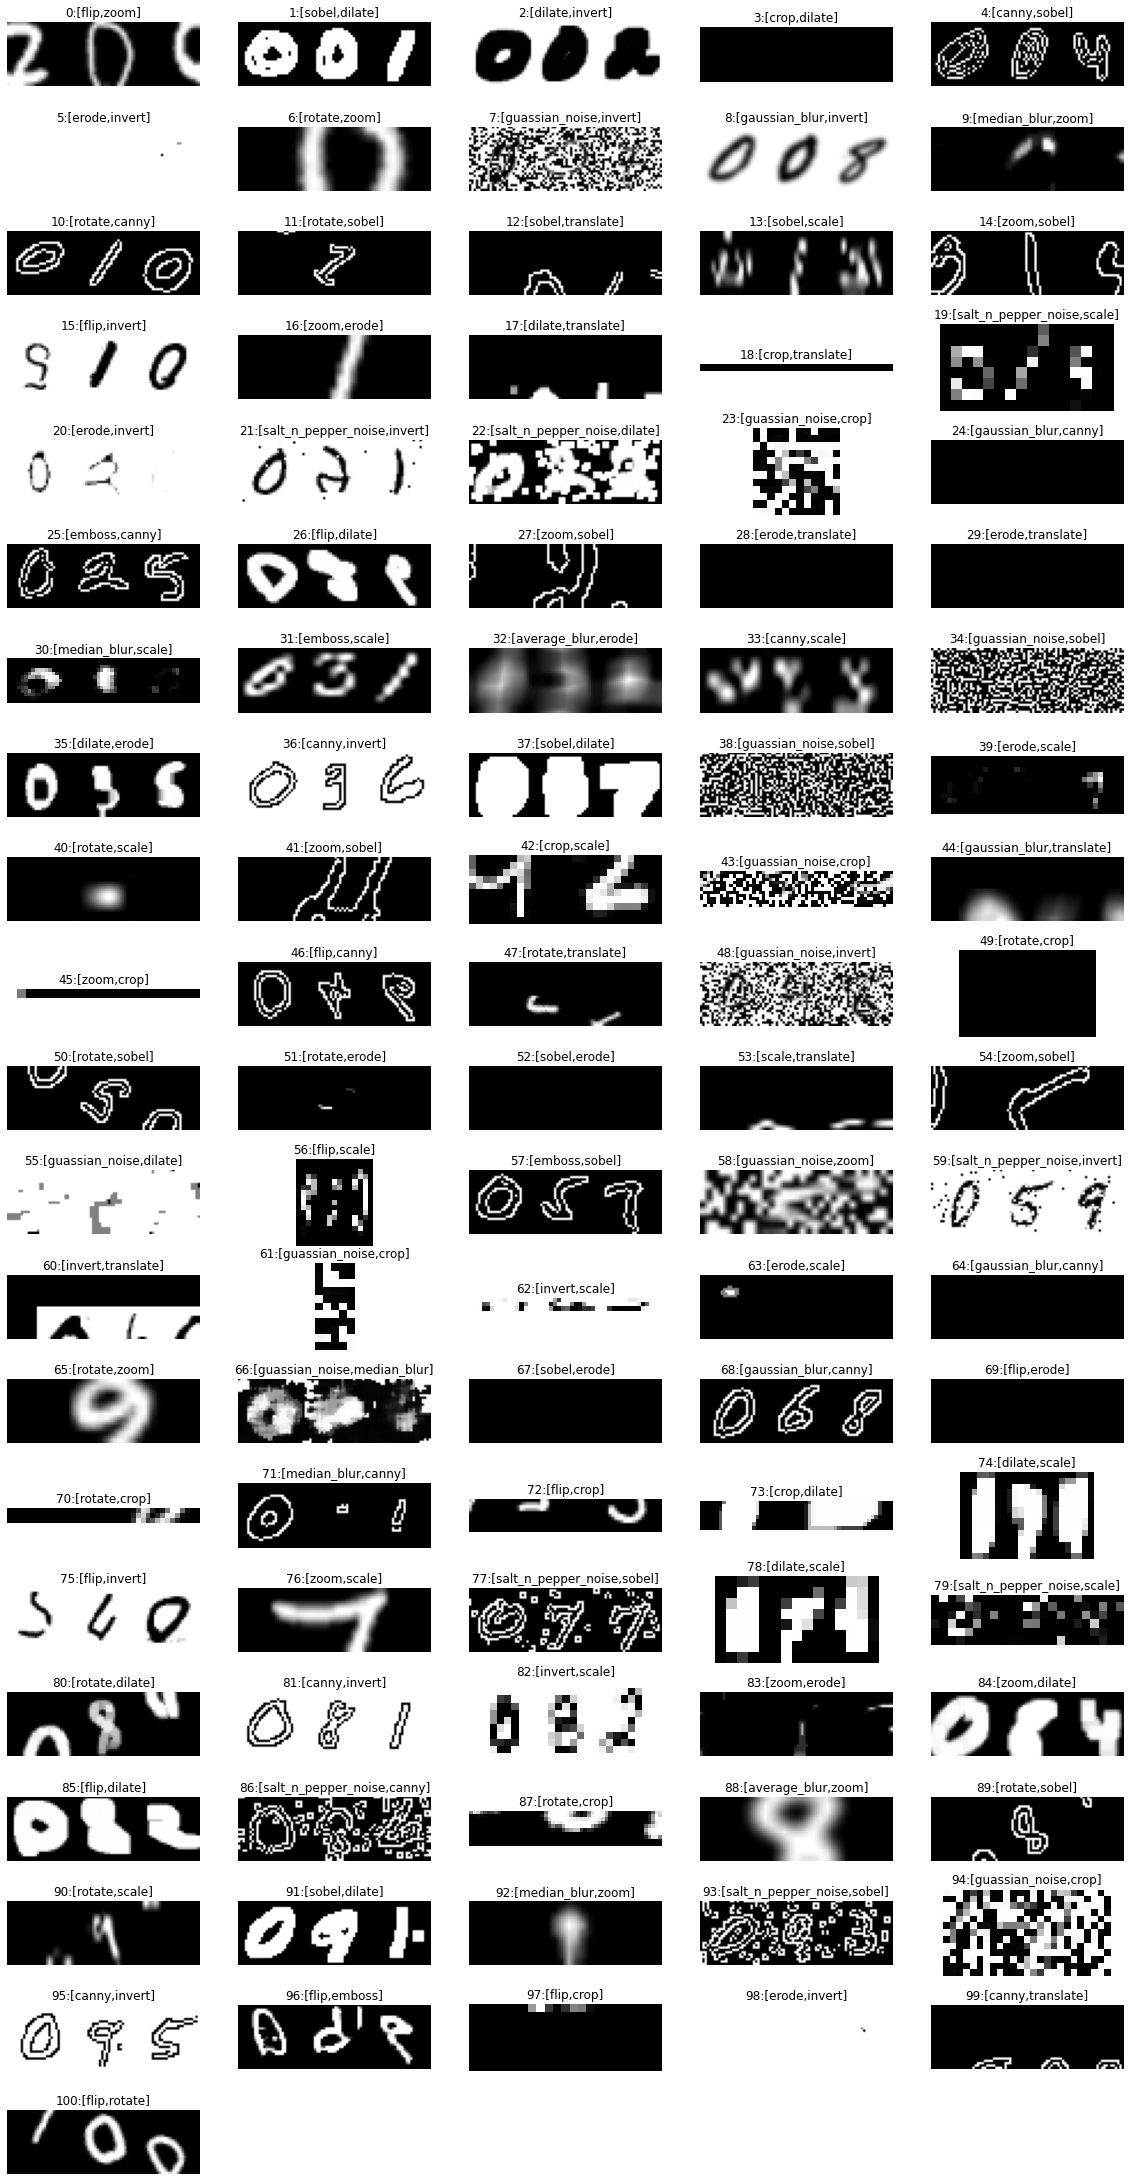

In [9]:
images = []
for k in new_train_data.keys():
    images.append(new_train_data[k][randint(len(new_train_data[k]))])
ra = RandomAugmentation(images,N=RandomAugmentation.augmentations)
ra.generate_augmented_images(2,True)

# Part one summary: 
* In this exsices we loaded mnist data set of hand written digits and built a new data set that based on 3 digit for each image
* Next we build a class that passes randomly different augmentations of images
* The role of augmentations is to make slight changes in images, thereby increasing our database

# Relevant augmentations
* 'canny' - an algorithm for identifying arcs / edges
* 'dilate' - helps reduce noise by enlarging edges in  the image (you can also use edge detection by reducing the original image)
* 'emboss' - highlighting the shadows can also be used to identify edges
* 'invert' - color inversion
* 'rotate' - rotation
* 'sobel' - an algorithm for identifying arcs / edges
* 'translate' - Move the image
* 'zoom' - Close an image to the center
* 'average_blur' - an algorithm for smoothing and reducing noise
* 'gaussian_blur' - A smoothing and noise reduction algorithm
* 'median_blur' - an algorithm for smoothing and reducing noise
* 'guassian_noise' - Add noises
* 'salt_n_pepper_noise' - Add noises

#### In cases that our training set is too small we can increase it by adding augmentations (like smoothing and highlighting the arches etc) to the images and thus adding new images to our training set. Adding more data will improve model performance. But we need to pay attention to irrelevant augmentations like
* rotate, translate and zoom

#### those augmentations can destroy the image content

## Irrelevant Augmentations:
* 'crop' - cuts the image in a certain place in a certain size
* 'flip' - Flip image vertically or horizontally
* 'erode' - this filter reduces the edges of the image (in our case it can also hide numbers)
* 'scale' - enlarging / reducing the image 

##### The above augmentations are not helpful because they can destroy the dimensions of our images and the content such as omitting numbers or reversing the numbers and can impair the training and performance of the model. 

# Summary:


 * In this exsices we loaded mnist data set of hand written digits and built a new data set that based on 3 digit for each image
 * Next we build a class that passes randomly different augmentations of images.
 * The role of augmentations is to make slight changes in images, thereby increasing our database.
